# Migration Data Download

Get occurrence data from the Global Biodiversity Information Facility
(GBIF)

## STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [22]:
import json
import requests
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
from io import BytesIO
import geopandas as gpd
import pandas as pd
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [1]:
%store -r

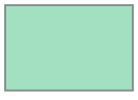

In [2]:
# Merge the GBIF observations into a single geometry
gbif_union = gbif_gdf.geometry.union_all().envelope
gbif_union

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Run the code below, which converts your Polygon to a special type of
GeoJSON needed for compatibility with the ArcGIS Feature Service. Check
out and explore this data structure. How would you extract the
geographic coordinates?</p></div></div>

In [3]:
# Convert geometry to geoJSON
gbif_geojson = gbif_union.__geo_interface__

gbif_geojson

{'type': 'Polygon',
 'coordinates': (((-129.34932, -25.36442),
   (-1.117499, -25.36442),
   (-1.117499, 60.40489),
   (-129.34932, 60.40489),
   (-129.34932, -25.36442)),)}

In [4]:
# Convert geometry to geoJSON
gbif_geojson = gbif_union.__geo_interface__

gbif_geojson

{'type': 'Polygon',
 'coordinates': (((-129.34932, -25.36442),
   (-1.117499, -25.36442),
   (-1.117499, 60.40489),
   (-129.34932, 60.40489),
   (-129.34932, -25.36442)),)}

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What type of Python object is this geoJSON? How will you get the
geographic coordinates only?</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>feature-key</code> with the coordinate key you noted
above.</li>
<li>Replace CRS with the CRS of your GBIF download. It should be
formatted as a 4-digit number, e.g. if the CRS is EPSG:1234, you should
put <code>1234</code> into Python.</li>
</ol></div></div>

In [7]:
# Construct ArcGIS-compatible JSON
arcgis_geom = json.dumps(dict(
    rings=gbif_geojson["coordinates"],
    spatialReference={"wkid": 4326}
))

### STEP 2: Download data from the ArcGIS FeatureService

In [ ]:
# Prepare API request
#eco_url = (
 #   "https://services5.arcgis.com/0AFsQflykfA9lXZn"
 #   "/ArcGIS/rest/services"
  #  "/WWF_Terrestrial_Ecoregions_Of_The_World_official_teow"
   # "/FeatureServer/0/query")
#eco_params = {
 #   "f": "geojson",
  #  "where": "1=1",
  #  "outFields": "area_km2",
  #  "returnGeometry": "true",
    # Return polygons containing any GBIF observation
  #  "spatialRel": "esriSpatialRelIntersects",  
  #  "geometryType": "esriGeometryPolygon",
    # Override web Mercator server default
  #  "inSR": "CRS",
   # "outSR": "CRS",
    # Must format geometry
   # "geometry": arcgis_geom}

# Submit API request
#eco_resp = requests.get(
#    eco_url, params=eco_params,
#    headers={"Accept-Encoding": "identity"})
# eco_resp.raise_for_status()

# Load binary data to DataFrame
#eco_gdf = gpd.read_file(BytesIO(eco_resp.content))

# Check the download

NameError: name 'gpd' is not defined

I am using the following code instead of the above. I asked ChatGPT to help me fix it as it wasnt working. 

In [ ]:


# Configure retry strategy
retry_strategy = Retry(
    total=3,  # number of retries
    backoff_factor=1,  # wait 1, 2, 4 seconds between retries
    status_forcelist=[429, 500, 502, 503, 504]  # HTTP status codes to retry on
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)

# Prepare API request
eco_url = (
    "https://services5.arcgis.com/0AFsQflykfA9lXZn"
    "/ArcGIS/rest/services"
    "/WWF_Terrestrial_Ecoregions_Of_The_World_official_teow"
    "/FeatureServer/0/query")
eco_params = {
    "f": "geojson",
    "where": "1=1",
    "outFields": "eco_code,area_km2",
    "returnGeometry": "true",
    "spatialRel": "esriSpatialRelIntersects",
    "geometryType": "esriGeometryPolygon",
    "inSR": "4326",
    "outSR": "4326",
    "geometry": arcgis_geom
}

# Submit API request with timeout and error handling
try:
    print("Requesting data from WWF API...")
    eco_resp = session.get(
        eco_url, 
        params=eco_params,
        headers={"Accept-Encoding": "identity"},
        timeout=30  # 30 second timeout
    )
    eco_resp.raise_for_status()
    print(f"Request successful! Response size: {len(eco_resp.content) / 1024:.1f} KB")
    
    # Load binary data to DataFrame
    print("Converting response to GeoDataFrame...")
    eco_gdf = gpd.read_file(BytesIO(eco_resp.content))
    print(f"Successfully loaded {len(eco_gdf)} ecoregions!")
    
except requests.exceptions.Timeout:
    print("Request timed out. The server took too long to respond.")
except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")
except Exception as e:
    print(f"Error processing data: {e}")
else:
    # Only run this if no exceptions occurred
    print("\nFirst few rows of the data:")
    display(eco_gdf.head())

Requesting data from WWF API...
Request successful! Response size: 31505.5 KB
Converting response to GeoDataFrame...
Successfully loaded 2000 ecoregions!

First few rows of the data:


,eco_code,area_km2,geometry
0,NT0702,125589,"POLYGON ((-67.98364 -13.79293, -67.98972 -13.7..."
1,NT0128,114506,"POLYGON ((-72.72287 -3.54497, -72.724 -3.5443,..."
2,NT0169,50675,"POLYGON ((-65.90067 6.64234, -65.90344 6.64368..."
3,NT0124,145963,"POLYGON ((-66.18742 6.44344, -66.19053 6.44392..."
4,NT1401,40894,"POLYGON ((-45.68811 -1.26541, -45.69585 -1.263..."


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Now, make a quick plot of your download to make sure that it worked
correctly.</p></div></div>

<Axes: >

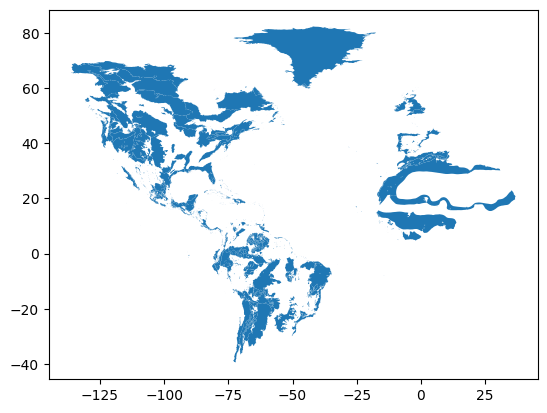

In [18]:
# Plot the ecoregion data
eco_gdf.plot()

### STEP 3 (Optional): Save your data

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Create a new directory in your data directory for the ecoregions
data.</li>
<li>Define a path to a Shapefile where you will save the ecoregions
data.</li>
<li>Save the ecoregions to the file.</li>
</ol></div></div>

In [23]:
# Save the ecoregion data


# Define the directory 
eco_dir = Path('/Users/niko2485/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Data_ES/species_migration_data/ecoregions')

# Create the directory if it doesn't exist
eco_dir.mkdir(parents=True, exist_ok=True)

# Define the shapefile path
eco_path = eco_dir / 'ecoregions.shp'

# Save the GeoDataFrame as a shapefile
eco_gdf.to_file(eco_path)

print(f"Saved ecoregion shapefile to: {eco_path}")

# Also save as GeoJSON (more web-friendly format)
geojson_path = eco_dir / 'ecoregions.geojson'
eco_gdf.to_file(geojson_path, driver='GeoJSON')
print(f"Saved ecoregion GeoJSON to: {geojson_path}")

Saved ecoregion shapefile to: /Users/niko2485/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Data_ES/species_migration_data/ecoregions/ecoregions.shp
Saved ecoregion GeoJSON to: /Users/niko2485/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Data_ES/species_migration_data/ecoregions/ecoregions.geojson


Saved visualization to: /Users/niko2485/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Data_ES/species_migration_data/thrush_ecoregions_map_20251027.png


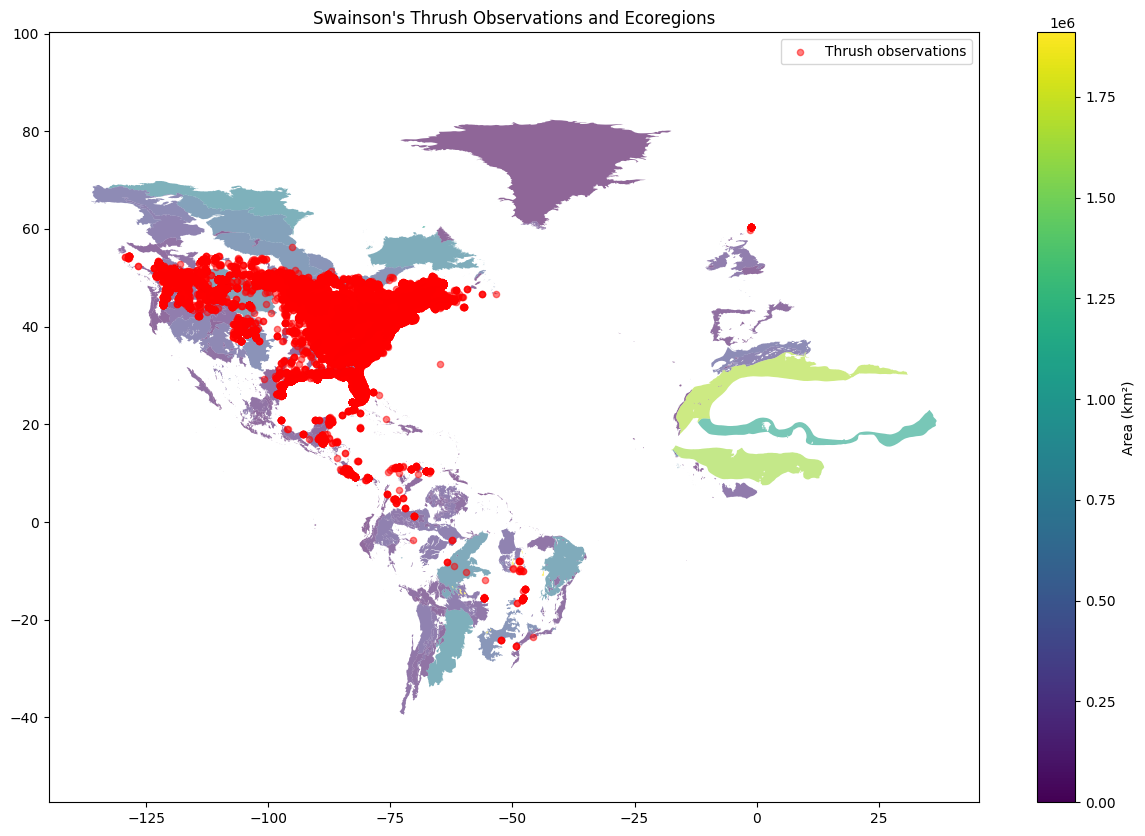


Summary Statistics:
Number of ecoregions: 2000
Total area covered: 278,774,709.00 km²


In [ ]:

# Create visualization
fig, ax = plt.subplots(figsize=(15, 10))

# Plot ecoregions
eco_gdf.plot(
    ax=ax,
    column='area_km2',
    legend=True,
    legend_kwds={'label': 'Area (km²)'},
    alpha=0.6
)

# Add GBIF points if available
if 'gbif_gdf' in globals():
    gbif_gdf.plot(
        ax=ax,
        color='red',
        markersize=20,
        alpha=0.5,
        label='Thrush observations'
    )

# Customize the plot
ax.set_title("Swainson's Thrush Observations and Ecoregions")
ax.legend()
plt.axis('equal')

# Save the visualization
plot_file = os.path.join(data_dir, f'thrush_ecoregions_map_{timestamp}.png')
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"Saved visualization to: {plot_file}")

# Display the plot
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Number of ecoregions: {len(eco_gdf)}")
print(f"Total area covered: {eco_gdf['area_km2'].sum():,.2f} km²")

